In [1]:
import numpy as np
import os, sys
import importlib
from tqdm.notebook import tqdm, trange
import pandas as pd
import json
import itertools
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from FewShotTestHandler import FewShotTestHandler, optimize_hyperparameters, find_hyperparameters, dataframe_format
from dataset import DatasetHandler
from similarity_metrics import Similarity
from plotting_utils import plot

ENV = os.environ["CONDA_DEFAULT_ENV"]
pd.options.display.max_rows = 200

/home/rob/vlm_benchmark/FewShotTestHandler.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
!pip install scikit-optimize
import skopt
import skopt.plots

### Settings

In [3]:
# VLM Params - vlm.____ keys are passed into VLM constructor
if ENV == "VLM_CLIP":
    from CLIP.CLIPVLM import ClipVLM as VLM
    vlm = VLM(num_frames=10)
elif ENV == "VLM_MILES":
    from MILES.wrapper import MILES_SimilarityVLM as VLM
    vlm = VLM()
elif ENV == "videoclip":
    from video_clip.video_clip import VideoClipVLM as VLM
    vlm = VLM(num_seconds=4, sample_strat="spread")
elif ENV == "VLM_UNIVL":
    from UNIVL.wrapper import UniVL_SimilarityVLM as VLM
    vlm = VLM()
elif ENV == "VLM_VTTWINS":
    from VTTWINS.wrapper import VTTWINS_SimilarityVLM as VLM
    vlm = VLM()
else:
    raise NotImplementedError

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


######USING ATTENTION STYLE:  frozen-in-time


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


######USING ATTENTION STYLE:  frozen-in-time


In [4]:
if False:
    from classifier import TipAdapterFewShotClassifier as Classifier
    HYPERPARAM_SPACE = [
        skopt.space.Real(0.1, 1000, name="alpha", prior="log-uniform"),
        skopt.space.Real(0.1, 100, name="beta", prior="log-uniform"),
        skopt.space.Real(1e-5, 1e-1, name="finetune_lr", prior="log-uniform"),
        skopt.space.Integer(0, 30, name="finetune_epochs"),
        skopt.space.Real(1e-4, 1, name="weight_decay", prior="log-uniform")
    ]
    
if True:
    from classifier.visual_prompt import VisualPromptPrependFewShotClassifier as Classifier
    HYPERPARAM_SPACE = [
        skopt.space.Integer(10, 100, name="epochs"),
        skopt.space.Real(1e-5, 1e-2, name="lr", prior="log-uniform"),
        skopt.space.Real(1e-5, 1e-1, name="weight_decay", prior="log-uniform"),
        skopt.space.Real(0, 1, name="momentum", prior="uniform")
    ]

In [5]:
DATASET = "smsm"
query_dataset = DatasetHandler(DATASET, "val")
support_dataset = DatasetHandler(DATASET, "train")
query_dataset.fill_cache(vlm)
support_dataset.fill_cache(vlm)

N_WAY = 100
N_SUPPORT_LIST = [4]#[0, 1, 2, 4, 8, 16, 32, 64]
N_QUERY = 4
N_EPISODES = 2

TESTHANDLER_RESULTS_FILE = f"hyperparam_search.{Classifier.__name__}.{query_dataset.id()}.csv"
test_handler = FewShotTestHandler(TESTHANDLER_RESULTS_FILE)

SKOPT_RESULTS_FILE = f"hyperparam_search.{Classifier.__name__}.{vlm.__class__.__name__}.{query_dataset.id()}.{'_'.join([str(x) for x in N_SUPPORT_LIST])}_shot.pkl"
SKOPT_N_CALLS = 1000

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

### Run SKOPT Hyperparameter Search

In [7]:
@skopt.utils.use_named_args(HYPERPARAM_SPACE)
def val_neg_accuracy(**classifier_params):
    classifier_params = dict(
        classifier_params,
        prompt_token_count=196,
        temperature=0.05,
        momentum=0.9
    )
    classifier = Classifier(vlm, **classifier_params)
    
    accuracies = []
    for n_support in N_SUPPORT_LIST:
        test_handler.run_few_shot_test(classifier, query_dataset, support_dataset, N_WAY, n_support, N_QUERY, N_EPISODES)

        # Find dataframe row with accuracy from this run
        filter_indices = np.ones(len(test_handler.results))
        for key, val in dataframe_format(classifier, query_dataset, support_dataset, N_WAY, n_support, N_QUERY, N_EPISODES).items():
            if pd.isna(val):
                filter_indices = filter_indices & pd.isna(test_handler.results[key])
            else:
                filter_indices = filter_indices & (test_handler.results[key] == val)
        matched_row = test_handler.results[filter_indices]
        accuracies.append(matched_row["accuracy"].values[0])
        
    return -1 * np.mean(accuracies)

skopt_pbar = None
def callback(current_skopt_results):
    skopt.dump(current_skopt_results, SKOPT_RESULTS_FILE)
    
    best_run_ind = np.argmin(current_skopt_results.func_vals)
    postfix_dict = {
        "best_acc": round(-1 * current_skopt_results.func_vals[best_run_ind], 5)
    }
    postfix_dict.update({
        param_space.name: round(current_skopt_results.x_iters[best_run_ind][i], 5)
        for i, param_space in enumerate(HYPERPARAM_SPACE)
    })
    skopt_pbar.update(1)
    skopt_pbar.set_postfix(postfix_dict)



if os.path.exists(SKOPT_RESULTS_FILE):
    old_skopt_results = skopt.load(SKOPT_RESULTS_FILE)
    x0 = old_skopt_results.x_iters
    y0 = old_skopt_results.func_vals
else:
    x0 = None
    y0 = None
skopt_pbar = tqdm(total=SKOPT_N_CALLS) 
skopt_results = skopt.gp_minimize(val_neg_accuracy, HYPERPARAM_SPACE, n_calls=SKOPT_N_CALLS, callback=callback, x0=x0, y0=y0)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Plot Hyperparam Search Results

In [8]:
skopt_results = skopt.load(SKOPT_RESULTS_FILE)

IndexError: list index out of range

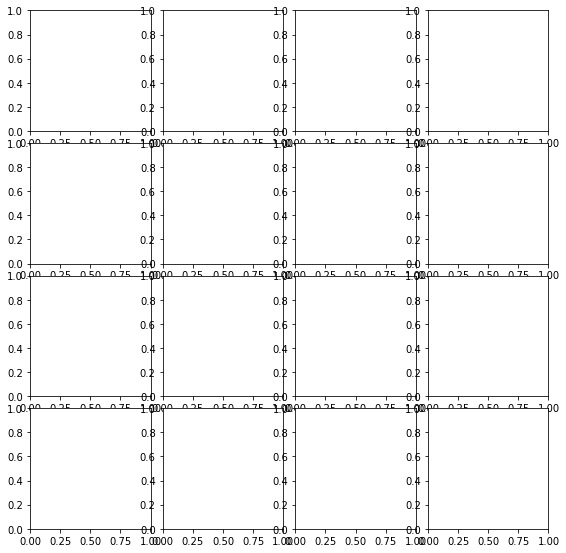

In [9]:
skopt.plots.plot_objective(skopt_results)
for i, hyperparam in enumerate(HYPERPARAM_SPACE):
    print(f"{hyperparam.name:20} {skopt_results.x[i]}")

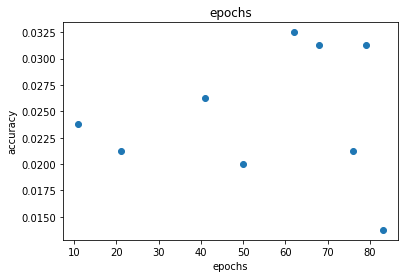

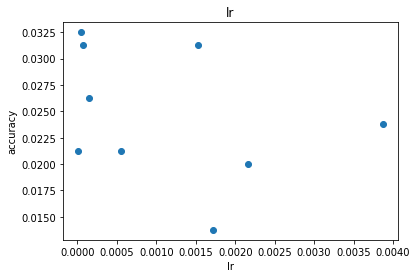

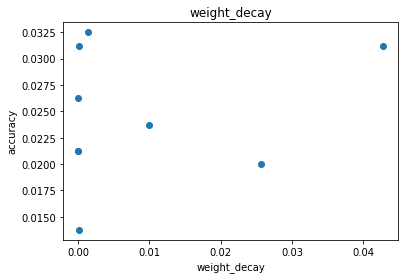

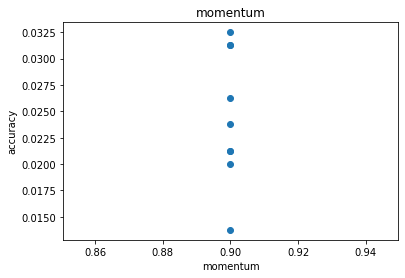

In [10]:
averaged_over_support = test_handler.results.groupby([col for col in test_handler.results.columns if col not in ["n_support", "accuracy", "accuracy_std"]], as_index=False, dropna=False).mean()

# Drop any sets which didn't complete the full list of support values (if interrupted, etc)
averaged_over_support = averaged_over_support[averaged_over_support["n_support"] == np.mean(N_SUPPORT_LIST)]

for hyperparam in HYPERPARAM_SPACE:
    plt.scatter(averaged_over_support[f"classifier.{hyperparam.name}"].values, averaged_over_support["accuracy"].values)
    plt.ylabel("accuracy")
    plt.xlabel(hyperparam.name)
    plt.title(hyperparam.name)
    plt.show()